In [1]:
import os
import re
import tqdm
import random
import unicodedata
import numpy as np
import matplotlib.pyplot as plt

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

In [2]:
seed = 781
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [3]:
def read_file(filepath):
    try:
        with open(filepath, mode='rt', encoding='utf-8') as file:
            content = file.readlines()
        return content
    except:
        raise Error(f'File {filepath} doesn\'t exist')

In [4]:
def unicode_to_ascii(s):
    # NFD => Normal Form Decompose
    # Mn => Non Marking Space
    return ''.join(c for c in unicodedata.normalize('NFD', s) \
                    if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    # Transform accented characters into unaccented ones
    s = unicode_to_ascii(s.strip())
    # Remove a sequence of whitespace characters
    s = re.sub(r'\s+', r' ', s)
    return s.strip()

In [5]:
%%time
pairs = [*zip(read_file('./data/europarl-v7.fr-en.fr'),
              read_file('./data/europarl-v7.fr-en.en'))]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples: {len(pairs):,}')

Number of examples: 2,007,723
CPU times: user 3.45 s, sys: 915 ms, total: 4.36 s
Wall time: 4.36 s


In [6]:
%%time
pairs = np.random.choice(pairs, size=100000, replace=False)
pairs = [*map(lambda pair: {k: normalize_string(v) for k, v in pair.items()},
              pairs)]
print(f'Number of examples after sampling: {len(pairs):,}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

Number of examples after sampling: 100,000
Example:
	FR => Les procedures par le biais desquelles de tels produits entrent et sortent de l'Union europeenne doivent etre ouvertes, transparentes et, par dessus tout, sures.
	EN => The procedures whereby such products come in and out of the European Union have to be open, transparent and, above all, safe.
CPU times: user 10.1 s, sys: 85.7 ms, total: 10.2 s
Wall time: 10.2 s


In [7]:
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           preprocessing=lambda x: x[::-1],
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True) # For pack_padded_sequence
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en')

examples = [Example.fromdict(data=pair, fields={'fr': ('src', FR),
                                                'en': ('dest', EN)})
            for pair in tqdm.tqdm(pairs)]
data = Dataset(examples, fields={'src': FR, 'dest': EN})

100%|██████████| 100000/100000 [00:32<00:00, 3050.84it/s]


In [8]:
train_data, valid_data, test_data = data.split(split_ratio=[0.8, 0.1, 0.1])
print(f'train set size: {len(train_data.examples)}')
print(f'valid set size: {len(valid_data.examples)}')
print(f'test set size: {len(test_data.examples)}')
print(vars(train_data.examples[0]))

train set size: 80000
valid set size: 10000
test set size: 10000
{'src': ['.', 'commence', 'a', 'olive', "d'", 'huile', "l'", 'de', 'campagne', 'la', 'que', 'parce', 'simplement', 'andalousie', 'en', 'chomeur', 'aucun', 'actuellement', 'a', 'y', "n'", 'il'], 'dest': ['there', 'is', 'no', 'unemployment', 'in', 'andalusia', 'at', 'present', 'simply', 'because', 'the', 'olive', 'harvest', 'has', 'begun', '.']}


In [9]:
%%time
FR.build_vocab(train_data,
               min_freq=2,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=2,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])

print(f'Length of FR vocabulary: {len(FR.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of FR vocabulary: 23,777
Length of EN vocabulary: 18,257
CPU times: user 1.41 s, sys: 3.77 ms, total: 1.42 s
Wall time: 1.42 s


# Modeling

## Encoder

The encoder remains the same

In [47]:
class Encoder(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, dropout):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_size, hidden_size)
        
    def forward(self, input_sequences, sequence_lengths):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            
        :return
            outputs: Tensor[seq_len, batch_size, hidden_size]
            hn: Tensor[num_layers=1, batch_size, hidden_size]
        """
        embedded = self.embedding(input_sequences)
        embedded = self.dropout(embedded)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, hn = self.gru(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return outputs, hn

## Decoder

In [61]:
class Decoder(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, dropout):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_size + hidden_size, hidden_size)
        self.fc = nn.Linear(embedding_size + hidden_size * 2, vocab_size)
        
    def forward(self, input_word_index, h_state, context):
        """
        :params
            input_word_index: Tensor[batch_size,]
            h_state: Tensor[num_layers=1, batch_size, hidden_size]
            context: Tensor[num_layers=1, batch_size, hidden_size]
            
        :return
            logit: Tensor[batch_size, vocab_size]
            h_state: Tensor[num_layers=1, batch_size, hidden_size]
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        embedded = self.dropout(embedded)
        # embedded: [1, batch_size, embedding_size]
        new_input = torch.cat((embedded, context), dim=2)
        # new_input: [1, batch_size, embedding_size + hidden_size]
        outputs, h_state = self.gru(new_input, h_state)
        # outputs: [1, batch_size, hidden_size]
        new_outputs = torch.cat((embedded, outputs, context), dim=2)
        # new_outputs: [1, batch_size, embedding_size + hidden_size + hidden_size]
        logit = self.fc(new_outputs.squeeze(0))
        return logit, h_state

# Sequence to sequence model

This puts encoder and decoder together.

In [64]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder, device):
        # assert encoder.n_layers == decoder.n_layers, 'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, 'Encoder and Decoder must have the same number of reccurrent hidden units'

        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, input_sequences, sequence_lengths, target_sequences, tf_ratio):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            target_sequences: Tensor[seq_len, batch_size]
            tf_ratio: float
            
        :return
            outputs: Tensor[seq_len - 1, batch_size, vocab_size]
                Since we ignore the SOS_TOKEN
        """
        _, h_state = self.encoder(input_sequences, sequence_lengths)
        
        seq_len, batch_size = target_sequences.size()
        outputs = torch.zeros(seq_len - 1, batch_size, self.decoder.vocab_size).to(self.device)
        word_index = target_sequences[0, :]
        context = h_state
        
        for t, idx in enumerate(range(1, seq_len)):
            output, h_state = self.decoder(word_index, h_state, context)
            # output: [batch_size, vocab_size]
            outputs[t] = output
            
            if random.random() < tf_ratio:
                word_index = target_sequences[idx, :]
            else:
                word_index = output.argmax(dim=1)
                
        return outputs

# Training routines

In [50]:
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)

In [51]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [52]:
def train_epoch(model, opt, loss_func, tf_ratio, data_it, grad_clip, epoch_text):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.train()
    for i, data in pbar:
        opt.zero_grad()
        outputs = model(*data.src, data.dest, tf_ratio)
        # *data.src: unpack input_sequences and sequence_lengths
        loss = loss_func(outputs.view(-1, model.decoder.vocab_size), data.dest[1:].view(-1))
        loss.backward()
        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        epoch_loss += loss.item()
        pbar.set_description(epoch_text + f'loss:     {epoch_loss / (i + 1):.3f} - ppl:     {np.exp(epoch_loss / (i + 1)):7.3f}')
    return epoch_loss / len(data_it), np.exp(epoch_loss / len(data_it))

In [53]:
def valid_epoch(model, loss_func, data_it, epoch_text):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.eval()
    with torch.no_grad():
        for i, data in pbar:
            outputs = model(*data.src, data.dest, 0) # Turn-off the teacher forcing
            loss = loss_func(outputs.view(-1, model.decoder.vocab_size), data.dest[1:].view(-1))
            epoch_loss += loss.item()
            pbar.set_description(epoch_text + f'val_loss: {epoch_loss / (i + 1):.3f} - val_ppl: {np.exp(epoch_loss / (i + 1)):7.3f}')
    return epoch_loss / len(data_it), np.exp(epoch_loss / len(data_it))

In [54]:
def train(model, opt, loss_func, train_it, valid_it, tf_ratio, n_epochs, grad_clip, save_to, filename):
    assert callable(loss_func)
    if not os.path.exists(save_to):
        !mkdir {save_to}
    
    history = {
        'loss': [],
        'val_loss': [],
        'ppl': [],
        'val_ppl': []
    }
    best_loss = [float('inf')]
    for epoch in range(n_epochs):
        epoch_text = f'Epoch: {epoch + 1:02d} - '
        loss, ppl = train_epoch(model=model, opt=opt, loss_func=loss_func, tf_ratio=tf_ratio,
                                data_it=train_it, grad_clip=grad_clip, epoch_text=epoch_text)
        val_loss, val_ppl = valid_epoch(model=model, loss_func=loss_func, data_it=valid_it, epoch_text=epoch_text)
        
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        history['ppl'].append(ppl)
        history['val_ppl'].append(val_ppl)
        
        # Saving
        if val_loss < best_loss[-1]:
            best_loss.append(val_loss)
            torch.save({
                'model': model.state_dict()
            }, f=os.path.join(save_to, filename))
            
        # Stop training
        try:
            if val_loss > best_loss[-2]:
                print('Stop training because the loss is increasing!')
                break
        except IndexError:
            pass
        
    return history

# Define and train models

In [55]:
EMBEDDING_DIM = 300
HIDDEN_SIZE = 512
# N_LAYERS = 2
DROPOUT = 0.25
GRAD_CLIP = 1.0
BATCH_SIZE = 64
N_EPOCHS = 15
TF_RATIO = 0
MAX_LEN = 50

In [56]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True, # For pack_padded_sequence
                              device=device)

In [65]:
encoder = Encoder(embedding_size=EMBEDDING_DIM,
                  vocab_size=len(FR.vocab),
                  hidden_size=HIDDEN_SIZE,
                  dropout=DROPOUT).to(device)
decoder = Decoder(embedding_size=EMBEDDING_DIM,
                  vocab_size=len(FR.vocab),
                  hidden_size=HIDDEN_SIZE,
                  dropout=DROPOUT).to(device)
seq2seq = SeqToSeqNet(encoder=encoder,
                      decoder=decoder,
                      device=device)
seq2seq.apply(init_weights).to(device)
opt_adam = optim.Adam(seq2seq.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {count_parameters(seq2seq):,}')

Number of parameters of the model: 49,057,765


In [66]:
%%time
history = train(model=seq2seq,
                opt=opt_adam,
                loss_func=criterion,
                train_it=train_iterator,
                valid_it=valid_iterator,
                tf_ratio=TF_RATIO,
                n_epochs=N_EPOCHS,
                grad_clip=GRAD_CLIP,
                save_to='./saved_models',
                filename='seq2seq-baseline-2.pt')

Epoch: 06 - val_loss: 4.649 - val_ppl: 104.506: 100%|██████████| 157/157 [00:25<00:00,  6.04it/s]

Stop training because the loss is increasing!
CPU times: user 45min 27s, sys: 43min 8s, total: 1h 28min 35s
Wall time: 1h 3min 17s


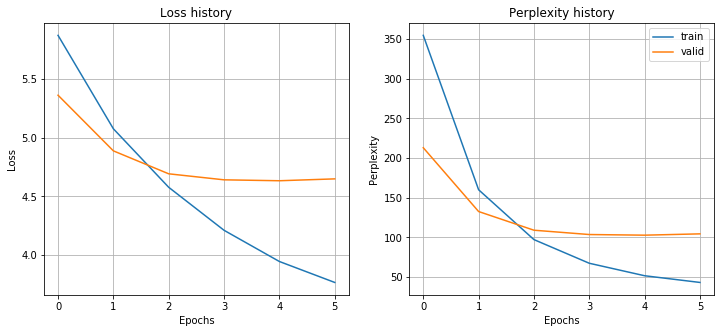

In [67]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
plt.legend()
plt.show()

In [69]:
val_loss, val_ppl = valid_epoch(model=seq2seq,
                                loss_func=criterion,
                                data_it=test_iterator,
                                epoch_text='Evaluation on test set - ')

Evaluation on test set - val_loss: 4.630 - val_ppl: 102.483: 100%|██████████| 157/157 [00:26<00:00,  6.01it/s]
